# Imports

In [1]:
import matplotlib.pyplot as plt
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np
import logging
from seqmatch import *
from google_kb_z_speaker.experiments import *
from google_kb_z_speaker.preprocessing import *
import pickle
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Text processing

In [2]:
bunches = get_bunches("transcriptions")

# Experiments

## Ensemble evaluation

Here we evaluate the first ensemble created between Google and KB and perform a grid search to find the optimal phonemizer and ratio threshold

In [3]:
# Get ensemble wer only on non agreement between kb and google 
def ensemble_wer_on_non_agreement(bunches, phonemizer, ratio_threshold, use_phonemizer):
    bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
    # Filter on non agreement
    bunch_list = [x for x in bunch_list if x["google"] != x["kb"]]
    #get ensemble outputs
    ensemble_outputs = [get_ensemble_output(bunch, phonemizer, ratio_threshold, use_phonemizer) for bunch in bunch_list]
    # Recreate bunches
    bunches = {k : [x[k] for x in bunch_list] for k in bunch_list[0]}
    
    return {**google_kb_wer(bunches), "ensemble_wer" : wer(bunches["correct"], ensemble_outputs)}
    
ensemble_wer_on_non_agreement(bunches, None, 0.6, False)

{'google_wer': 0.2388326384752829,
 'kb_wer': 0.23049434187016082,
 'ensemble_wer': 0.18205280921183245}

In [3]:
experiment = ensemble
kwargs = {
    "bunches" : bunches,
    "use_phonemizer" : True
}
args = [
    #[ensemble],
    #[1],
    [
        #"./models/deep-phonemizer-se.pt",
        "./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt"
    ],
    np.linspace(0.5,0.7, num=5)
]
# Convert phonemizer paths to phonemizers
phoneme_dict = read_phoneme_dict("models/stress_lex_mtm.txt")
args[0] = [ phonemizer_wrapper(init_phonemizer("cuda", x), phoneme_dict=phoneme_dict, include_stress_marks=False, batch_size=300)
           for x in args[0]]
experiment = ensemble
res = grid(experiment,args,kwargs, stub=False)

Could not find a suitable model architecture for the phonemizer at model path:./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt


AttributeError: module 'dp.model.model' has no attribute 'device'

In [5]:
res[0][1]["kb_wer"], res[0][1]["kb_wer"]

(0.19164265129682997, 0.19164265129682997)

In [6]:
res[0][1]["google_wer"], res[0][1]["google_wer"]

(0.1983669548511047, 0.1983669548511047)

In [5]:
res[0][1]["ensemble-wer"], res[0][1]["ensemble-wer"]

(0.1697086135126481, 0.1697086135126481)

In [ ]:
with open("output/ensemble_eval", "rb") as f:
    res = pickle.load(f)

In [17]:
res[0]

((<function phonemes.phonemizer_wrapper.<locals>.phonemizer_to_return(texts: Union[str, List[str]], lang)>,
  0.6),
 {'google_wer': 0.1983669548511047,
  'kb_wer': 0.19164265129682997,
  'ensemble-wer': 0.1525776496958053,
  'ensemble_outputs': ['ja nu har jag också startat',
   'ja',
   'nej det var en gammal veteranmoped',
   'jå det var väldigt kul det var det',
   'men du jag tänkte jag tog fram de här fraserna nu',
   'i min telefon',
   'man skulle bara kunna läsa även om det blir hur',
   'hur säger goddag yxskaft som helst kanske man kan läsa dem',
   'om jag säger hej till exempel så säger du hur står det till så står bredvid ser du dem också',
   'så gör man det som en liten dialog',
   'fast det kommer att bli bara rappakalja',
   'ja det kanske går',
   'eller kanske oom jag får säger hej hur står det till',
   'och sen tar du nästa rad med två liksom',
   'fattar du',
   'hej hur står det till',
   'hej hur står det till',
   'var kanske inte världens bästa idé',
   'd läg

In [57]:
#filtered = filter(lambda x : "deep-phon" in x[0][2] and x[0][-1] >= 0.6 and x[0][-1] < 0.7, res)
filtered = list(filter(None, res))
x = min(filtered, key= lambda x: x[1]["ensemble-wer"].mean)[1]["ensemble-wer"]
arg = np.argmin([x[1]["ensemble-wer"].mean for x in filtered])
print(f"{x.mean} ± {x.std}", arg)
filtered[arg]

0.1520973422990714 ± 0 205


((<function google_kb_z_speaker.experiments.ensemble(phonemizer, ratio_threshold, bunches=None, device=None, use_phonemizer=None)>,
  1,
  <function phonemes.phonemizer_wrapper.<locals>.phonemizer_to_return(texts: Union[str, List[str]], lang)>,
  0.6154135338345864),
 {'google_wer': <experiment_helpers.ExperimentResult at 0x7f048d61a160>,
  'kb_wer': <experiment_helpers.ExperimentResult at 0x7f048d61a100>,
  'ensemble-wer': <experiment_helpers.ExperimentResult at 0x7f048d61a130>})

### Error analysis

Research questions
- On which examples was WER improved with the ensemble
- On which examples is the ensemble WER worse than before?
- On which examples is grapheme ensemble WER better than phoneme ensemble WER 
- On which examples is grapheme ensemble WER worse than phoneme ensemble WER 

In [26]:
def err_anal(bunches):
    phonemizer = phonemizer_wrapper(init_phonemizer("cuda", "models/deep-phonemizer-se.pt", stress_marks=True), None, include_stress_marks=True)
    res_graph = ensemble(phonemizer, 0.6, bunches=bunches, device="cuda", use_phonemizer=False)
    res_phoneme = ensemble(phonemizer, 0.6, bunches=bunches, device="cuda", use_phonemizer=True)
    # Copy bunches
    bunches = {k:v for k,v in bunches.items()}
    bunches["grapheme"] = res_graph["ensemble_outputs"]
    bunches["phoneme"] = res_phoneme["ensemble_outputs"]
    bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
    # Subsets for rqs
    rq1 = []
    rq2 = []
    rq3 = []
    rq4 = []
    rq5 = []
    rq6 = []
    for bunch in bunch_list:
        len_correct = len(bunch["correct"])
        kb_wer = wer(bunch["correct"], bunch["kb"])
        graph_wer = wer(bunch["correct"], bunch["grapheme"])
        phoneme_wer = wer(bunch["correct"], bunch["phoneme"])
        if phoneme_wer < kb_wer:
            rq1.append(bunch)
        if phoneme_wer > kb_wer:
            rq2.append(bunch)
        if graph_wer < phoneme_wer:
            rq3.append(bunch)
        if graph_wer > phoneme_wer:
            rq4.append(bunch)
        if graph_wer < kb_wer:
            rq5.append(bunch)
        if graph_wer > kb_wer:
            rq6.append(bunch)
    
    return [rq1,rq2,rq3,rq4,rq5,rq6]

In [22]:
        
for i,x in enumerate(err_anal(bunches)):
    print("===================")
    print(f"Len Rq{i+1} :", len(x), "percentage: ", len(x)/ 911)
    samples = random.sample(x,k=5)
    for xi in samples:
        print(":::::::::::::::::::::::")
        print("Correct ", xi["correct"])
        print("Google ", xi["google"])
        print("KB ", xi["kb"])
        print("PhonemeEns ",  xi["phoneme"])
        print("Grapheme ",  xi["grapheme"])

  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

Len Rq1 : 161 percentage:  0.17672886937431395
:::::::::::::::::::::::
Correct  och hur mår du och så där
Google  och hur mår du och så där
KB  och hur mår du och sådär
PhonemeEns  och hur mår du och så där
Grapheme  och hur mår du och så där
:::::::::::::::::::::::
Correct  att jag kanske har fyrtio stycken på min lista som jag är
Google  att jag kanske har 40 stycken på min lista som jag är
KB  att jag kanske har fyrtio stycken på min lista som jag r
PhonemeEns  att jag kanske har fyrtio stycken på min lista som jag är
Grapheme  att jag kanske har fyrtio stycken på min lista som jag är
:::::::::::::::::::::::
Correct  ja
Google  ja
KB  a
PhonemeEns  ja
Grapheme  ja
:::::::::::::::::::::::
Correct  ja jag tänkte häromdagen på också när ni ska komma hit och hälsa på egentligen och var ni ska sova allihopa
Google  ja jag tänkte häromdagen på också när ni ska komma hit och hälsa på egentligen att han ska sova
KB  ja jag tänkte häromdan på också när ni ska komma hit och hälsa på egentlige

## Phonemizer dict evaluation

Running the different phonemizers and testing their outputs with the provied stres__lex dictionary

In [10]:
def phonemizer_eval(model_path, device=None, stub=None):
    print("Stub is ", stub)
    phonemizer = init_phonemizer(device, model_path)
    phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
    print("Preprocessing dict")
    keys_order = list(phoneme_dict.keys())
    # Downsample
    values_order = [phoneme_dict[k] for k in keys_order]
    print("Running phonemizer")
    count_correct = 0
    outputs = []
    pbar = tqdm(list(enumerate(keys_order)))
    for i,k in pbar:
        true_phonemes = "".join(phoneme_dict[k])
        if not stub:
            phon_output = phonemizer(k,"se")
        else:
            phon_output = "a-form"
        outputs.append(phon_output)
        if phon_output==true_phonemes:
            count_correct += 1

        if i % 2000 == 0:
            pbar.set_postfix_str(f"Accuracy: {count_correct / len(keys_order):.3f}")
    output_dict = {k:v for k,v in zip(keys_order, outputs)}

    return {
        "accuracy" : count_correct / len(keys_order),
        "output_dict" : output_dict
    }

In [11]:
model_paths = [
            'models/deep-phonemizer-se.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',
            
]
kwargs= {
    "device" : "cuda",
    "stub" : True
}
res = grid(phonemizer_eval, [model_paths], kwargs, stub=False)
res

  0%|          | 0/3 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

[(('models/deep-phonemizer-se.pt',),
  {'accuracy': 0.0,
   'output_dict': {'a': 'a-form',
    'a-aktier': 'a-form',
    'a-banan': 'a-form',
    'a-ekonomi': 'a-form',
    'a-et': 'a-form',
    'a-final': 'a-form',
    'a-finalen': 'a-form',
    'a-flyg': 'a-form',
    'a-form': 'a-form',
    'a-gruppen': 'a-form',
    'a-juniorer': 'a-form',
    'a-juniorerna': 'a-form',
    'a-juniorlaget': 'a-form',
    'a-kamper': 'a-form',
    'a-kassa': 'a-form',
    'a-kassan': 'a-form',
    'a-kassor': 'a-form',
    'a-kassorna': 'a-form',
    'a-lag': 'a-form',
    'a-lagare': 'a-form',
    'a-lagarna': 'a-form',
    'a-laget': 'a-form',
    'a-lagets': 'a-form',
    'a-lagsjuniorerna': 'a-form',
    'a-lagspelare': 'a-form',
    'a-lagsspelare': 'a-form',
    'a-landskamper': 'a-form',
    'a-landslag': 'a-form',
    'a-landslaget': 'a-form',
    'a-listan': 'a-form',
    'a-ljud': 'a-form',
    'a-ljudet': 'a-form',
    'a-n': 'a-form',
    'a-nummer': 'a-form',
    'a-pojke': 'a-form',
   

In [14]:
[x[0] for x in res]

[('models/deep-phonemizer-se.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',)]

In [12]:
print([(x[0],x[1]["accuracy"]) for x in res])
with open("output/phonemizer_eval_res", "wb") as f:
    pickle.dump(res,f)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 'accuracy'

### Analysis of data

In [91]:
with open("output/phonemizer_eval_res", "rb") as f:
    res = pickle.load(f)

model2word2pred = {x[0][0]: x[1]["output_dict"] for x in res} #DD

models = ["deepphon", "bestmodel", "model40k"]
ids = ["deep-p", "best_model" , "model_step_40k"]
def key_translator(x):
    mask = [id_i in x for id_i in ids]
    return models[mask.index(True)]

model2word2pred = { key_translator(k) : v for k,v in model2word2pred.items()}

true_dict = read_phoneme_dict("models/stress_lex_mtm.txt")

model2word2pred["correct"] = {k : "".join(v) for k,v in true_dict.items()}


word2model2pred = { word : {model : model2word2pred[model][word] for model in model2word2pred} for word in model2word2pred["correct"]}

def filter_phonemizer_predictions(word2model2pred, deepphoncorrect, bestmodelcorrect, model40kcorrect):
    result = {}
    mask = [deepphoncorrect, bestmodelcorrect, model40kcorrect]
    for word, model2pred in word2model2pred.items():
        mask_value= [model2pred["deepphon"] == model2pred["correct"],
                     model2pred["bestmodel"] == model2pred["correct"],
                     model2pred["model40k"] == model2pred["correct"]
                    ]
        if mask_value == mask:
            result[word] = model2pred
    return {"result" : result}


In [92]:
args = [
    [word2model2pred],
    [True,False],
    [True,False],
    [True,False]
]
res = grid(filter_phonemizer_predictions, args, {}, stub=False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [117]:
# deepphon correct bestmodel correct 
import random
random.seed(0)
for x in res:
    print("=========================")
    print("deephon correct, bestmodel orrect, 40k correct")
    print(x[0][1:])
    print("Count of filter: ", len(x[1]["result"]))
    print("Percentage: ", len(x[1]["result"])/ sum([ len(x[1]["result"]) for x in res]))
    # Draw 5 samples from each category
    words_sample = random.sample(x[1]["result"].keys(), k=5)
    for word in words_sample:
        print(word, x[1]["result"][word]["correct"] ,x[1]["result"][word]["deepphon"],x[1]["result"][word]["bestmodel"], x[1]["result"][word]["model40k"], sep=" | ")
    print("words sample: ", words_sample)
print("Sum of counts :", sum([ len(x[1]["result"]) for x in res]))
print("Length of dict: ", len(word2model2pred))

deephon correct, bestmodel orrect, 40k correct
(True, True, True)
Count of filter:  169341
Percentage:  0.4840540934544176
nordebrand | n"o2:rdebr`and | n"o2:rdebr`and | n"o2:rdebr`and | n"o2:rdebr`and
priskänslig | pr"i2:stj'enslig | pr"i2:stj'enslig | pr"i2:stj'enslig | pr"i2:stj'enslig
beboelig | beb'o2:elig | beb'o2:elig | beb'o2:elig | beb'o2:elig
jangberg | j"angb`ä3rj | j"angb`ä3rj | j"angb`ä3rj | j"angb`ä3rj
staller | st'alër | st'alër | st'alër | st'alër
words sample:  ['nordebrand', 'priskänslig', 'beboelig', 'jangberg', 'staller']
deephon correct, bestmodel orrect, 40k correct
(True, True, False)
Count of filter:  27224
Percentage:  0.07781865372356998
milutinovic | milutin'å2:vittj | milutin'å2:vittj | milutin'å2:vittj | milut'i2:nåvittj
krönlind | kr"ö2:nl`ind | kr"ö2:nl`ind | kr"ö2:nl`ind | kr"ö2:nl'ind
vimlet | v'imlët | v'imlët | v'imlët | v"imlët
översköterska | "ö2:vërsj`ö2:terska | "ö2:vërsj`ö2:terska | "ö2:vërsj`ö2:terska | "ö2:versj`ö2:terska
hovegård | h"å2:veg`å2

## Parameterized agreement

We relax the notion of agreement and we consider that KB and Google agree only when their lcs is over a percentage of their maximum length. We then consider that in cases of agreement we keep only the largest common subsequence (LCS) of the two as the prediction.

In the following cells we test this for different threshhold levels, we produce first the WERs per threshold level and also the percentage of utterances where there is agreement

In [13]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, "models/deep-phonemizer-se.pt", **kwargs)

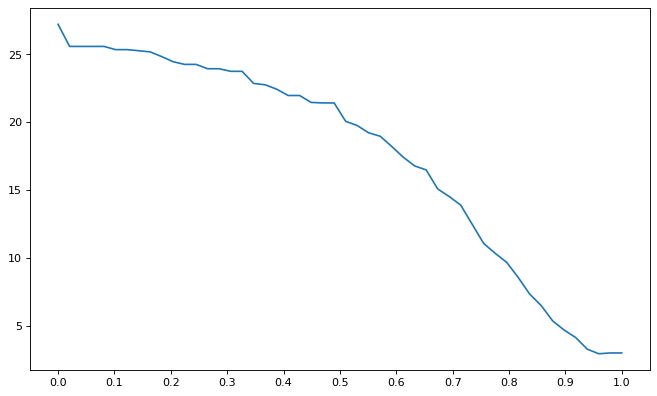

In [15]:
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])

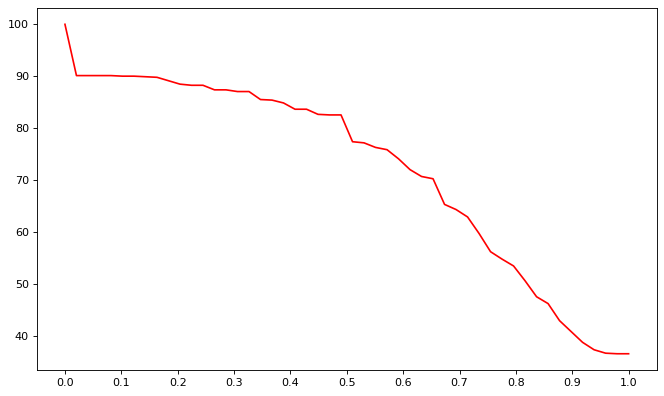

In [16]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

## Pairwise evaluation

Here we test KB and Google, calculating their WERs under different scenarios (words, phoneme_words, singular phonemes) and also statistics percentages about 
agreement, overlap and mean-lcs

In [20]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : False,
}
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True
}
res = experiment_repeats(experiment, 5, bunches, "./models/deep-phonemizer-se.pt", **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

agreement: 0.36553238199780463±0.0
g_correct_kb_not : 0.2768166089965398±0.0
kb_correct_g_not : 0.15051903114186851±0.0
agreement_not_correct: 0.0990990990990991±0.0
both_incorrect_disagreement: 0.5726643598615917±0.0
google_wer: 0.1983669548511047±0.0
kb_wer: 0.19164265129682997±0.0
google-avg-length: 6.300768386388584±0.0
correct-avg-length: 6.856201975850714±0.0
kb-avg-length: 6.711306256860593±0.0
lcs-mean: 0.7239754234570818±0.0
error_index_overlap: 0.3029810298102981±0.0


## Randomness in phonemizer

Here we explore the phenomenon that the phonemizer can output multiple pronounciations of some words, but refrains to do it when it is called with an argument that is List[str]

In [ ]:
phonemizer = phonemizer("Hello my name is nick", lang="se")

In [ ]:
set([phonemizer("ja", "se") for x in range(100)])

In [ ]:
set(phonemizer(["ja" for x in range(10000)], "se"))

# Error analysis

### Sort sentences based on WER  

In [3]:
def bunch_normalized_wer(bunch, model):
    return wer(bunch["correct"], bunch[model]) * len(bunch["correct"].split())

bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]


for bunch in bunch_list:
    bunch["ensemble"] = get_ensemble_output(bunch, None, 0.6, use_phonemizer=False) 
    
sorted_bunch_list = sorted(bunch_list, key=lambda x : bunch_normalized_wer(x,"ensemble"))
sorted_bunch_list.reverse()

In [4]:
wer_sums =  { k : sum(bunch_normalized_wer(x,k) for x in bunch_list) for k in bunch_list[0]}

In [5]:
wer_sums

{'google': 1239.0, 'correct': 0.0, 'kb': 1197.0, 'ensemble': 953.0}

In [6]:
cbunch = sorted_bunch_list[6]

cbunch

curr_wers = {k : bunch_normalized_wer(cbunch,k) for k,v in cbunch.items()}
curr_wers

{'google': 'skulle vi ha gjort det då johan sådär då tänker jag hoppas inte att väggarna ska vara bra isolera du att det liksom',
 'correct': 'skulle vi ha gjort nåt då är ju han så att då tänker ju han på sånt där att väggarna ska vara bra isolerade och att det liksom',
 'kb': 'skulle vi ha gjort nego då är ju han så där att då tänker ju han på sånt där att väggarna ska vara bra isolerade och att liksom',
 'ensemble': 'skulle vi ha gjort nego då johan sådär då tänker ju han på sånt där att väggarna ska vara bra isolera du att  liksom'}

{'google': 13.0, 'correct': 0.0, 'kb': 3.0, 'ensemble': 9.0}

In [7]:
get_kb_google_unmatched_blocks(cbunch)

[('det', 'nego'),
 ('johan sådär', 'är ju han så där att'),
 ('jag hoppas inte', 'ju han på sånt där'),
 ('isolera du', 'isolerade och'),
 ('det', '')]

# Visualization

In [ ]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))